# The Image Classification Dataset
:label:`sec_fashion_mnist`

In :numref:`sec_naive_bayes`, we trained a naive Bayes classifier,
using the MNIST dataset introduced in 1998 :cite:`LeCun.Bottou.Bengio.ea.1998`. 
While MNIST had a good run as a benchmark dataset, 
even simple models by today's standards achieve classification accuracy over 95%
making it unsuitable for distinguishing between stronger models and weaker ones. 
Today, MNIST serves as more of sanity checks than as a benchmark.
To up the ante just a bit, we will focus our discussion in the coming sections
on the qualitatively similar, but comparatively complex Fashion-MNIST 
dataset :cite:`Xiao.Rasul.Vollgraf.2017`, which was released in 2017.

In [1]:
%use @file[../djl.json]
class StopWatch {

    // Record multiple running times.
    private val times: ArrayList<Double> = arrayListOf<Double>()
    private var tik: Long = 0 

    init {
        start()
    }

    fun start() {
        tik = System.nanoTime()
    }

    fun stop(): Double {
        times.add(nanoToSec(System.nanoTime() - tik))
        return times[times.size - 1]
    }

    fun getTimes() : ArrayList<Double>{
        return times
    }

    // Return average time
    fun avg() : Double {
        return sum() / times.size.toDouble()
    }

    // Return the sum of time
    fun sum() : Double {
        var sum = 0.0
        for (d in times) {
            sum += d
        }
        return sum
    }

    // Return the accumulated times
    fun cumsum() : ArrayList<Double> {
        var cumsumList = arrayListOf<Double>()
        var currentSum = 0.0
        for (d in times) {
            currentSum += d
            cumsumList.add(currentSum)
        }
        return cumsumList
    }

    // Convert nano seconds to seconds
    private fun nanoToSec(nanosec: Long) : Double{
        return nanosec.toDouble() / 1E9;
    }
}

//%load ../utils/djl-imports
//%load ../utils/StopWatch.java
//%load ../utils/ImageUtils.java

In [2]:
import ai.djl.modality.cv.Image;
import ai.djl.modality.cv.output.BoundingBox;
import ai.djl.modality.cv.output.DetectedObjects;
import ai.djl.modality.cv.output.Rectangle;
import ai.djl.ndarray.NDArray;

import java.awt.Color;
import java.awt.Font;
import java.awt.FontMetrics;
import java.awt.Graphics2D;
import java.awt.RenderingHints;
import java.awt.image.BufferedImage;
//import java.util.ArrayList;
//import java.util.Arrays;
//import java.util.List;

object ImageUtils {

    fun showImages(
            images: Array<BufferedImage>, labels: Array<String>, width: Int, height: Int) : BufferedImage {
        val col = Math.min(1280 / width, images.size)
        val row = (images.size + col - 1) / col

        val textHeight = 28
        val w = col * (width + 3)
        val h = row * (height + 3) + textHeight
        val output = BufferedImage(w + 3, h + 3, BufferedImage.TYPE_INT_RGB)
        val g = output.createGraphics()
        g.setRenderingHint(RenderingHints.KEY_ANTIALIASING, RenderingHints.VALUE_ANTIALIAS_ON)
        g.setPaint(Color.LIGHT_GRAY)
        g.fill(java.awt.Rectangle(0, 0, w + 3, h + 3))
        g.setPaint(Color.BLACK)

        val font = g.getFont();
        val metrics = g.getFontMetrics(font);
        for (i in 0.. images.size-1) {
            val x = (i % col) * (width + 3) + 3
            val y = (i / col) * (height + 3) + 3

            val tx = x + (width - metrics.stringWidth(labels[i])) / 2;
            val ty = y + ((textHeight - metrics.getHeight()) / 2) + metrics.getAscent();
            g.drawString(labels[i], tx, ty);

            val img = images[i];
            g.drawImage(img, x, y + textHeight, width, height, null);
        }
        g.dispose();
        return output;
    }

    fun showImages(images:Array<BufferedImage>, width: Int, height: Int) : BufferedImage{
        val col = Math.min(1280 / width, images.size);
        val row = (images.size + col - 1) / col;

        val w = col * (width + 3);
        val h = row * (height + 3);
        val output = BufferedImage(w + 3, h + 3, BufferedImage.TYPE_INT_RGB);
        val g = output.createGraphics();
        g.setRenderingHint(RenderingHints.KEY_ANTIALIASING, RenderingHints.VALUE_ANTIALIAS_ON);
        g.setPaint(Color.LIGHT_GRAY);
        g.fill(java.awt.Rectangle(0, 0, w + 3, h + 3));
        for (i in 0..images.size-1) {
            val x = (i % col) * (width + 3) + 3;
            val y = (i / col) * (height + 3) + 3;

            val img = images[i];
            g.drawImage(img, x, y, width, height, null);
        }
        g.dispose();
        return output;
    }

    fun drawBBoxes(img: Image, boxes: NDArray , labels: Array<String>?) {
        val nlabels = 
        if (labels == null) {
            Array<String>(boxes.size(0).toInt()) { "" }
        } else {
            labels
        }

        val classNames = mutableListOf<String>()
        val prob = mutableListOf<Double>();
        val boundBoxes = mutableListOf<BoundingBox>()
        for (i in 0..boxes.size(0)-1) {
            val box = boxes.get(i);
            val rect = bboxToRect(box);
            classNames.add(nlabels[i.toInt()]);
            prob.add(1.0);
            boundBoxes.add(rect);
        }
        val detectedObjects = DetectedObjects(classNames, prob, boundBoxes);
        img.drawBoundingBoxes(detectedObjects);
    }

    fun bboxToRect(bbox: NDArray ) : Rectangle {
        val width = bbox.getFloat(2) - bbox.getFloat(0);
        val height = bbox.getFloat(3) - bbox.getFloat(1);
        return Rectangle(bbox.getFloat(0).toDouble(), bbox.getFloat(1).toDouble(), width.toDouble(), height.toDouble());
    }
}


In [3]:
import ai.djl.basicdataset.cv.classification.*
import ai.djl.training.dataset.Record
import java.awt.image.BufferedImage
import java.awt.Graphics2D
import java.awt.Color
fun getLong(nm: String, n: Long): Long {
    val name = System.getProperty(nm)
    return if (null == name) n.toLong() else name.toLong()
}

## Getting the Dataset

Just as with MNIST, DJL makes it easy to download and load the Fashion-MNIST dataset into memory via the `FashionMnist` class contained in `ai.djl.basicdataset`.
We briefly work through the mechanics of loading and exploring the dataset below. 
Please refer to :numref:`sec_naive_bayes` for more details on loading data.

Let us first define the `getDataset()` function 
that obtains and reads the Fashion-MNIST dataset. 
It returns the dataset for the training set or the validation set depending
on the passed in `usage` (`Dataset.Usage.TRAIN` for training and `Dataset.Usage.TEST` for validation). 
You can then call `getData(manager)` on the dataset to get the corresponding iterator.
It also takes in the `batchSize` and `randomShuffle` which dictates
the size of each batch and whether to randomly shuffle the data respectively.

In [4]:
val batchSize = 256;
val randomShuffle = true;

val mnistTrain = FashionMnist.builder()
        .optUsage(Dataset.Usage.TRAIN)
        .setSampling(batchSize, randomShuffle)
        .optLimit(getLong("DATASET_LIMIT", Long.MAX_VALUE))
        .build();

val mnistTest = FashionMnist.builder()
        .optUsage(Dataset.Usage.TEST)
        .setSampling(batchSize, randomShuffle)
        .optLimit(getLong("DATASET_LIMIT", Long.MAX_VALUE))
        .build();

mnistTrain.prepare();
mnistTest.prepare();

val manager = NDManager.newBaseManager();

Fashion-MNIST consists of images from 10 categories, each represented 
by 60k images in the training set and by 10k in the test set. 
Consequently the training set and the test set 
contain 60k and 10k images, respectively.

In [5]:
println(mnistTrain.size())
println(mnistTest.size())

60000
10000


The images in Fashion-MNIST are associated with the following categories: 
t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag and ankle boot. 
The following function converts between numeric label indices and their names in text.

In [6]:
// Saved in the FashionMnist class for later use
fun getFashionMnistLabels(labelIndices: IntArray) : Array<String>{
    val textLabels = arrayOf("t-shirt", "trouser", "pullover", "dress", "coat",
                   "sandal", "shirt", "sneaker", "bag", "ankle boot")
    val convertedLabels = mutableListOf<String>()
    for (i in 0..labelIndices.size-1) {
        convertedLabels.add(textLabels[labelIndices[i]])
    }
    return convertedLabels.toTypedArray()
}

fun getFashionMnistLabel(labelIndice: Int) : String{
    val textLabels = arrayOf("t-shirt", "trouser", "pullover", "dress", "coat",
                   "sandal", "shirt", "sneaker", "bag", "ankle boot")
    return textLabels[labelIndice]
}

We can now create a function to visualize these examples.
Don't worry too much about the specifics of visualization.
This is simply just to help intuitively understand the data.
We essentially read in a number of datapoints and convert their
RGB value from 0-255 to between 0-1. We then set the color as grayscale
and then display it along with their labels in an external window.

In [7]:
// Saved in the FashionMnistUtils class for later use
fun showImages(
        dataset:ArrayDataset , number: Int, width: Int, height: Int, scale: Int, manager: NDManager ) : BufferedImage {
    // Plot a list of images
    var images = mutableListOf<BufferedImage>()
    var labels = mutableListOf<String>()
    for (i in 0..number-1) {
        val record = dataset.get(manager, i.toLong());
        val array = record.getData().get(0).squeeze(-1);
        val y = record.getLabels().get(0).getFloat().toInt()
        images.add(toImage(array, width, height))
        labels.add(getFashionMnistLabel(y))
    }
    val w = images.first().getWidth() * scale;
    val h = images.first().getHeight() * scale;

    return ImageUtils.showImages(images.toTypedArray(), labels.toTypedArray(), w, h);
}

fun toImage( array : NDArray, width: Int,height: Int) : BufferedImage{
    System.setProperty("apple.awt.UIElement", "true");
    var img = BufferedImage(width, height, BufferedImage.TYPE_BYTE_GRAY);
    val g = img.getGraphics();
    for (i in 0..width-1) {
        for (j in 0 .. height-1) {
            val c = array.getFloat(j.toLong(), i.toLong()) / 255 // scale down to between 0 and 1
            g.setColor(Color(c, c, c)); // set as a gray color
            g.fillRect(i, j, 1, 1);
        }
    }
    g.dispose();
    return img;
}

Here are the images and their corresponding labels (in text)
for the first few examples in the training dataset.


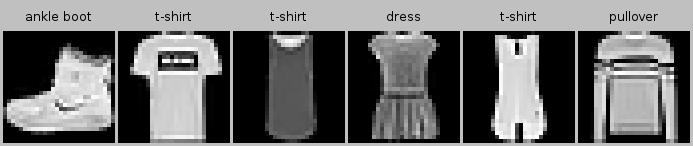

In [8]:
val SCALE = 4;
val WIDTH = 28;
val HEIGHT = 28;

showImages(mnistTrain, 6, WIDTH, HEIGHT, SCALE, manager)

## Reading a Minibatch

To make our life easier when reading from the training and test sets,
we use the `getData(manager)`.
Recall that at each iteration, `getData(manager)` 
reads a minibatch of data with size `batchSize` each time.
We then get the X and y by calling `getData()` and `getLabels()` on each batch respectively.

Note: During training, reading data can be a significant performance bottleneck, 
especially when our model is simple or when our computer is fast. 

Let us look at the time it takes to read the training data.

In [9]:
val stopWatch = StopWatch();
stopWatch.start();
for (batch in mnistTrain.getData(manager)) {
    val x = batch.getData().head();
    val y = batch.getLabels().head();
}
println("%.2f sec".format(stopWatch.stop()))

4.82 sec


We are now ready to work with the Fashion-MNIST dataset in the sections that follow.

## Summary

* Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. 
 * We will use this dataset in subsequent sections and chapters to evaluate various classification algorithms.
* We store the shape of each image with height $h$ width $w$ pixels as $h \times w$ or `(h, w)`.
* Data iterators are a key component for efficient performance. Rely on well-implemented iterators that exploit multi-threading to avoid slowing down your training loop.

## Exercises

1. Does reducing the `batchSize` (for instance, to 1) affect read performance?
1. Use the DJL documentation to see which other datasets are available in `ai.djl.basicdataset`.